In [11]:
%run Common.ipynb

In [34]:
#!pip install twython
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/edc529/nltk_data...


True

# Question 16
<p>In this part, we will be doing sentiment analysis on the tweets using the NLTK package. Analyzing the sentiment can help us determine fan opinion over time. This can tell us whether people have a negative, neutral, or positive view of a topic as real-world events are happening in real time.</p>

In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [6]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

wnl = nltk.wordnet.WordNetLemmatizer()

In [174]:
from sklearn.feature_extraction.text import CountVectorizer

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

analyzer = CountVectorizer().build_analyzer()

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def lemmatize_rmv_numeric(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not is_number(word))

In [17]:
import pandas as pd
import glob
import os

import pytz
utc_tz = pytz.UTC
pst_tz = pytz.timezone('America/Los_Angeles')

basedir = 'data/ECE219_tweet_data/'
datafilenames = [i for i in glob.iglob(basedir + '*.txt')]
hashtags = [f.split('#')[1].replace('.txt','') for f in datafilenames]
datafilenames

['data/ECE219_tweet_data/tweets_#gopatriots.txt',
 'data/ECE219_tweet_data/tweets_#nfl.txt',
 'data/ECE219_tweet_data/tweets_#patriots.txt',
 'data/ECE219_tweet_data/tweets_#superbowl.txt',
 'data/ECE219_tweet_data/tweets_#sb49.txt',
 'data/ECE219_tweet_data/tweets_#gohawks.txt']

In [43]:
'''
Instead of loading the entire file, you can read the files, line by line and keep the information you need.
Store the processed data in pickle objects.
'''
import json
import os

OVERWRITE_PICKLE_OBJECTS = False

def extract_feature_from_tweet(tweet_dict,feature_name):
    if feature_name == "time": 
        return tweet_dict["citation_date"]
    if feature_name == "time_ori":
        return tweet_dict["firstpost_date"]
    if feature_name == "citetime":
        return pd.to_datetime(tweet_dict["citation_date"], unit='s')
    if feature_name == "citetime_pst":
        return pd.to_datetime(tweet_dict["citation_date"], unit='s').tz_localize(utc_tz).astimezone(pst_tz)
    if feature_name == "tweet_polarity":
        return sid.polarity_scores(" ".join(list(lemmatize_rmv_numeric(tweet_dict["tweet"]["text"]))))
    return ""


feature_names = ["time", "time_ori", "citetime", "citetime_pst", "tweet_polarity"]

for fn in log_progress(datafilenames):
    pickle_file = fn+'.q16.pkl.gz'
    if os.path.isfile(pickle_file) and not OVERWRITE_PICKLE_OBJECTS:
        print(pickle_file+'\texists.')
    else:    
        tweets_features = dict() 
        for f in feature_names:
            tweets_features[f] = []
        
        with open(fn,'r') as d:
            for ind, line in enumerate(d):      
                tweet_dict = json.loads(line) 
                for f in feature_names:
                    feature_value = extract_feature_from_tweet(tweet_dict, f)
                    tweets_features[f].append(feature_value)
        pickle_write(tweets_features, pickle_file)
        print(pickle_file+'\tsaved.')

VBox(children=(HTML(value=''), IntProgress(value=0, max=6)))

data/ECE219_tweet_data/tweets_#gopatriots.txtq16.pkl.gz	saved.
data/ECE219_tweet_data/tweets_#nfl.txtq16.pkl.gz	saved.
data/ECE219_tweet_data/tweets_#patriots.txtq16.pkl.gz	saved.
data/ECE219_tweet_data/tweets_#superbowl.txtq16.pkl.gz	saved.
data/ECE219_tweet_data/tweets_#sb49.txtq16.pkl.gz	saved.
data/ECE219_tweet_data/tweets_#gohawks.txtq16.pkl.gz	saved.


In [46]:
# load the extracted features
df_features = {}

for hashtag in log_progress(hashtags):
    tweet_features = pickle_load(basedir + 'tweets_#' + hashtag +'.txt.q16.pkl.gz')
    df_features[hashtag] = pd.DataFrame(tweet_features)

VBox(children=(HTML(value=''), IntProgress(value=0, max=6)))

In [47]:
df_features['gohawks'].head()

citetime              citetime_pst        time    time_ori  \
0 2015-01-17 18:19:38 2015-01-17 10:19:38-08:00  1421518778  1419804875   
1 2015-01-14 18:18:56 2015-01-14 10:18:56-08:00  1421259536  1419864008   
2 2015-01-17 04:21:59 2015-01-16 20:21:59-08:00  1421468519  1419881240   
3 2015-01-17 04:21:37 2015-01-16 20:21:37-08:00  1421468497  1419883838   
4 2015-01-17 04:18:56 2015-01-16 20:18:56-08:00  1421468336  1419962615   

                                      tweet_polarity  \
0  {'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound...   
1  {'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'comp...   
2  {'neg': 0.243, 'neu': 0.576, 'pos': 0.181, 'co...   
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
4  {'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp...   

                                          tweet_text  
0  I &lt;3 our defense! #GoHawks http://t.co/U1pc...  
1  twelfth dogs are ready! #gohawks #dogslife htt...  
2  "Oh no big deal, just NFC West Champs and the ...  
3  At http://t.co/Vd0RWOeAed -- #Seahawks #12thMA...  
4  Good luck at Michigan, Jim Harbaugh. #GoHawks ...

In [175]:
df_features['patriots'].head()

citetime              citetime_pst        time    time_ori  \
0 2015-01-14 15:23:24 2015-01-14 07:23:24-08:00  1421249004  1419805279   
1 2015-01-16 02:06:11 2015-01-15 18:06:11-08:00  1421373971  1419963931   
2 2015-01-17 17:59:06 2015-01-17 09:59:06-08:00  1421517546  1419999683   
3 2015-01-17 00:43:47 2015-01-16 16:43:47-08:00  1421455427  1420037428   
4 2015-01-15 14:41:24 2015-01-15 06:41:24-08:00  1421332884  1420131448   

                                      tweet_polarity  \
0  {'neg': 0.188, 'neu': 0.812, 'pos': 0.0, 'comp...   
1  {'neg': 0.105, 'neu': 0.622, 'pos': 0.273, 'co...   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
4  {'neg': 0.12, 'neu': 0.788, 'pos': 0.091, 'com...   

                                          tweet_text  
0  FRENCH SUPERMARKETS SELL ISLAMIC BOOKS CALL FO...  
1  Do the #Patriots Capture their 4th Ring this y...  
2  Who do you have?!?! #nfl #NFLPlayoffs #Packers...  
3  “@RochieWBZ: Bill Belichick at his last Presse...  
4  RT Obama is a #traitor &amp; committed #treaso...

In [63]:
# transform data into time and polarities
df_polarities = {}
for hashtag in log_progress(hashtags):
    df_feature = df_features[hashtag]
    df_feature_pol = df_feature.drop(['tweet_text','citetime','time','time_ori'], axis=1)
    df_feature_pol['pol_neg'] = [i['neg'] for i in df_feature_pol.tweet_polarity]
    df_feature_pol['pol_neu'] = [i['neu'] for i in df_feature_pol.tweet_polarity]
    df_feature_pol['pol_pos'] = [i['pos'] for i in df_feature_pol.tweet_polarity]
    df_feature_pol['pol_cmp'] = [i['compound'] for i in df_feature_pol.tweet_polarity]
    df_feature_pol.drop('tweet_polarity', axis=1, inplace=True)
    df_polarities[hashtag] = df_feature_pol

VBox(children=(HTML(value=''), IntProgress(value=0, max=6)))

In [64]:
df_polarities['gohawks'].head()

citetime_pst  pol_neg  pol_neu  pol_pos  pol_cmp
0 2015-01-17 10:19:38-08:00    0.000    0.800    0.200   0.1280
1 2015-01-14 10:18:56-08:00    0.000    0.762    0.238   0.3612
2 2015-01-16 20:21:59-08:00    0.243    0.576    0.181  -0.3612
3 2015-01-16 20:21:37-08:00    0.000    1.000    0.000   0.0000
4 2015-01-16 20:18:56-08:00    0.000    0.576    0.424   0.7096

In [67]:
df_polarities['gopatriots'].head()

citetime_pst  pol_neg  pol_neu  pol_pos  pol_cmp
0 2015-01-14 09:45:41-08:00    0.000    0.868    0.132   0.4404
1 2015-01-14 14:44:31-08:00    0.000    1.000    0.000   0.0000
2 2015-01-15 09:11:15-08:00    0.054    0.814    0.132   0.4588
3 2015-01-14 17:26:29-08:00    0.115    0.885    0.000  -0.2960
4 2015-01-16 08:55:32-08:00    0.000    0.484    0.516   0.7506

In [69]:
df_polarities['nfl'].head()

citetime_pst  pol_neg  pol_neu  pol_pos  pol_cmp
0 2015-01-17 09:59:06-08:00      0.0    1.000    0.000   0.0000
1 2015-01-14 10:08:26-08:00      0.0    1.000    0.000   0.0000
2 2015-01-17 10:17:43-08:00      0.0    1.000    0.000   0.0000
3 2015-01-15 19:58:05-08:00      0.0    1.000    0.000   0.0000
4 2015-01-14 09:44:31-08:00      0.0    0.774    0.226   0.6222

In [70]:
df_polarities['superbowl'].head()

citetime_pst  pol_neg  pol_neu  pol_pos  pol_cmp
0 2015-01-16 20:21:37-08:00      0.0    1.000    0.000   0.0000
1 2015-01-16 20:06:19-08:00      0.0    1.000    0.000   0.0000
2 2015-01-14 12:22:37-08:00      0.0    1.000    0.000   0.0000
3 2015-01-14 10:48:18-08:00      0.0    0.867    0.133   0.3182
4 2015-01-15 02:00:31-08:00      0.0    1.000    0.000   0.0000

### We can see from above that hashtags relating to superbowl teams are more positive, and the more general #nfl and #superbowl hashtags are pretty neutral

# Sentiment Analysis Over Time

<p>We will look at the compound polarity score over time for the hashtags. The compound score is a combination of the negative, neutral, and positive score. A compound score of 0 is neutral, < 0 is negative sentiment, > 0 is positive sentiment. We will look at the average score within 1 hour windows.</p>

## #gohawks Sentiment Analysis

In [191]:
df_pol_hawks = df_polarities['gohawks'].sort_values(by='citetime_pst')
df_pol_hawks_1h = pd.DataFrame(df_pol_hawks.groupby(pd.Grouper(key='citetime_pst', freq="60Min")).agg({'pol_cmp':'mean'}))
df_pol_hawks_1h.columns = ['pol_cmp_avg']
df_pol_hawks_1h.fillna(value=0, inplace=True)

In [189]:
df_pol_hawks_1h.head()

pol_cmp_avg
citetime_pst                          
2015-01-14 00:00:00-08:00       7.1726
2015-01-14 01:00:00-08:00       4.8510
2015-01-14 02:00:00-08:00       4.6431
2015-01-14 03:00:00-08:00       2.8711
2015-01-14 04:00:00-08:00       6.6455

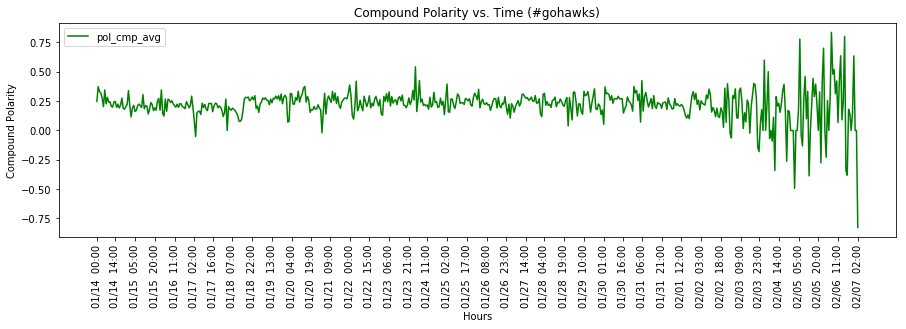

In [192]:
idx = df_pol_hawks_1h.index
groupcols = [idx.year, idx.month, idx.day, idx.hour]

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(3.95)
ax = df_pol_hawks_1h.groupby(groupcols).agg({'pol_cmp_avg':'mean'}).plot(ax=ax, kind="line", color="green")
#ax = df_pol_hawks_1h.groupby(groupcols).agg({'pol_cmp_avg':'mean'}).plot(ax=ax, kind="bar", color="green", width=1)
ax.set_title('Compound Polarity vs. Time (#gohawks)')
ax.set_xlabel('Hours')
ax.set_ylabel('Compound Polarity')

plt.xticks(rotation=90)
xtick_idx = np.linspace(0, len(df_pol_hawks_1h) - 1, 40).astype(int)
xtick_labels = df_pol_hawks_1h.index[xtick_idx]
xtick_labels = ["%02d/%02d  %02d:%02d" %(i.month,i.day,i.hour,i.minute) for i in xtick_labels]
ax.set_xticks(xtick_idx)
_ = ax.set_xticklabels(xtick_labels)

<p>We can see that the sentiment for #gohawks is somewhat positive before the game and varies wildly during and after the game. This particular game was notable because the Seahawks had the chance to win the game at the very end of the game, but failed spectacularly. As a result, the Patriots came back from behind and stole the championship. The heavily negative sentiment toward the end is likely to be attributed to this reason, as the Seahawks were heavily criticized for their decision.</p>

## #patriots Sentiment Analysis

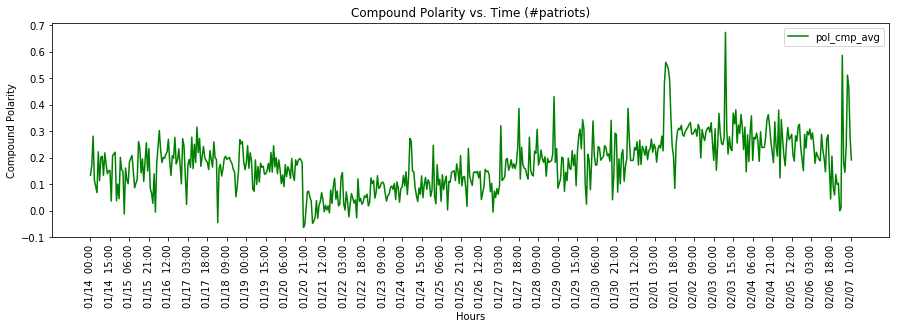

In [185]:
df_pol_pats = df_polarities['patriots'].sort_values(by='citetime_pst')
df_pol_pats_1h = pd.DataFrame(df_pol_pats.groupby(pd.Grouper(key='citetime_pst', freq="60Min")).agg({'pol_cmp':'mean'}))
df_pol_pats_1h.columns = ['pol_cmp_avg']
df_pol_pats_1h.fillna(value=0, inplace=True)

idx = df_pol_pats_1h.index
groupcols = [idx.year, idx.month, idx.day, idx.hour]

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(3.95)
ax = df_pol_pats_1h.groupby(groupcols).agg({'pol_cmp_avg':'mean'}).plot(ax=ax, kind="line", color="green")
ax.set_title('Compound Polarity vs. Time (#patriots)')
ax.set_xlabel('Hours')
ax.set_ylabel('Compound Polarity')

plt.xticks(rotation=90)
xtick_idx = np.linspace(0, len(df_pol_pats_1h) - 1, 40).astype(int)
xtick_labels = df_pol_pats_1h.index[xtick_idx]
xtick_labels = ["%02d/%02d  %02d:%02d" %(i.month,i.day,i.hour,i.minute) for i in xtick_labels]
ax.set_xticks(xtick_idx)
_ = ax.set_xticklabels(xtick_labels)

<p>The sentiment for #patriots is generally positive. The Patriots won the Superbowl so there isn't many negative sentiments.</p>

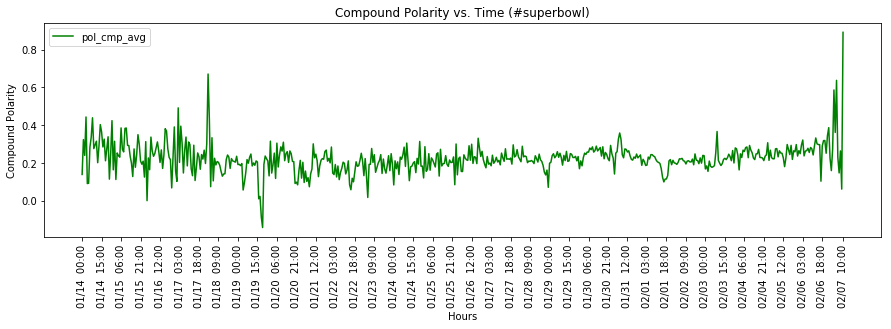

In [186]:
df_pol_sb = df_polarities['superbowl'].sort_values(by='citetime_pst')
df_pol_sb_1h = pd.DataFrame(df_pol_sb.groupby(pd.Grouper(key='citetime_pst', freq="60Min")).agg({'pol_cmp':'mean'}))
df_pol_sb_1h.columns = ['pol_cmp_avg']
df_pol_sb_1h.fillna(value=0, inplace=True)

idx = df_pol_sb_1h.index
groupcols = [idx.year, idx.month, idx.day, idx.hour]

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(3.95)
ax = df_pol_sb_1h.groupby(groupcols).agg({'pol_cmp_avg':'mean'}).plot(ax=ax, kind="line", color="green")
ax.set_title('Compound Polarity vs. Time (#superbowl)')
ax.set_xlabel('Hours')
ax.set_ylabel('Compound Polarity')

plt.xticks(rotation=90)
xtick_idx = np.linspace(0, len(df_pol_sb_1h) - 1, 40).astype(int)
xtick_labels = df_pol_sb_1h.index[xtick_idx]
xtick_labels = ["%02d/%02d  %02d:%02d" %(i.month,i.day,i.hour,i.minute) for i in xtick_labels]
ax.set_xticks(xtick_idx)
_ = ax.set_xticklabels(xtick_labels)

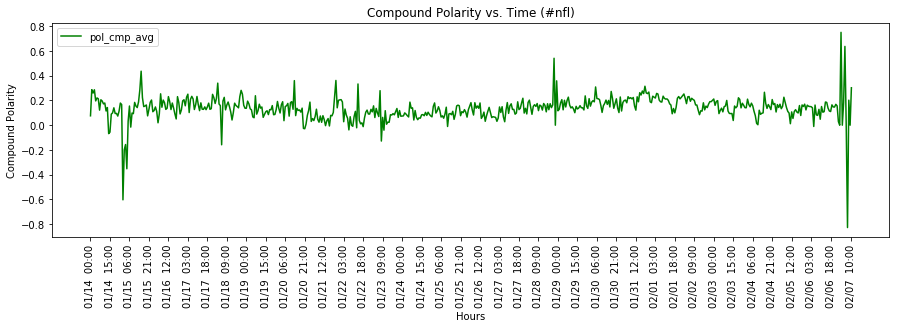

In [187]:
df_pol_nfl = df_polarities['nfl'].sort_values(by='citetime_pst')
df_pol_nfl_1h = pd.DataFrame(df_pol_nfl.groupby(pd.Grouper(key='citetime_pst', freq="60Min")).agg({'pol_cmp':'mean'}))
df_pol_nfl_1h.columns = ['pol_cmp_avg']
df_pol_nfl_1h.fillna(value=0, inplace=True)

idx = df_pol_nfl_1h.index
groupcols = [idx.year, idx.month, idx.day, idx.hour]

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(3.95)
ax = df_pol_nfl_1h.groupby(groupcols).agg({'pol_cmp_avg':'mean'}).plot(ax=ax, kind="line", color="green")
ax.set_title('Compound Polarity vs. Time (#nfl)')
ax.set_xlabel('Hours')
ax.set_ylabel('Compound Polarity')

plt.xticks(rotation=90)
xtick_idx = np.linspace(0, len(df_pol_nfl_1h) - 1, 40).astype(int)
xtick_labels = df_pol_nfl_1h.index[xtick_idx]
xtick_labels = ["%02d/%02d  %02d:%02d" %(i.month,i.day,i.hour,i.minute) for i in xtick_labels]
ax.set_xticks(xtick_idx)
_ = ax.set_xticklabels(xtick_labels)

## Sentiment Analysis on Superbowl Day

<p>This part takes a closer look at the sentiment during a single day period on Superbowl day. We aggregate the compound score using summation instead of mean so that strong sentiments can be brought out in the graph.</p>

### #gohawks

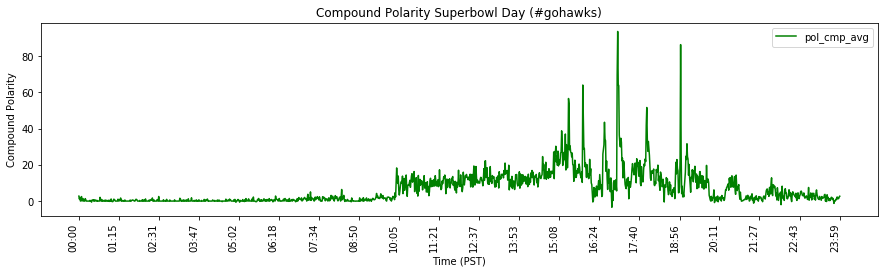

In [178]:
start = pd.to_datetime('2015-02-01 00:00:00-08:00')
stop = pd.to_datetime('2015-02-02 00:00:00-08:00')

df_pol_hawks = df_polarities['gohawks'].sort_values(by='citetime_pst')
df_pol_hawks = df_pol_hawks[(df_pol_hawks['citetime_pst'] >= start) & (df_pol_hawks['citetime_pst'] < stop)]
df_pol_hawks_1m = pd.DataFrame(df_pol_hawks.groupby(pd.Grouper(key='citetime_pst', freq="1Min")).agg({'pol_cmp':'sum'}))
df_pol_hawks_1m.columns = ['pol_cmp_avg']
df_pol_hawks_1m.fillna(value=0, inplace=True)

idx = df_pol_hawks_1m.index
groupcols = [idx.year, idx.month, idx.day, idx.hour, idx.minute]

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(3.95)
fig.autofmt_xdate()
ax = df_pol_hawks_1m.groupby(groupcols).agg({'pol_cmp_avg':'sum'}).plot(ax=ax, kind="line", color="green")
#ax = df_pol_hawks_1m.groupby(groupcols).agg({'pol_cmp_avg':'mean'}).plot(ax=ax, kind="bar", color="green", width=1.0)
ax.set_title('Compound Polarity Superbowl Day (#gohawks)')
ax.set_xlabel('Time (PST)')
ax.set_ylabel('Compound Polarity')

plt.xticks(rotation=90)
xtick_idx = np.linspace(0, len(df_pol_hawks_1m) - 1, 20).astype(int)
xtick_labels = df_pol_hawks_1m.index[xtick_idx]
xtick_labels = ["%02d:%02d" %(i.hour,i.minute) for i in xtick_labels]
ax.set_xticks(xtick_idx)
_ = ax.set_xticklabels(xtick_labels)


### #patriots

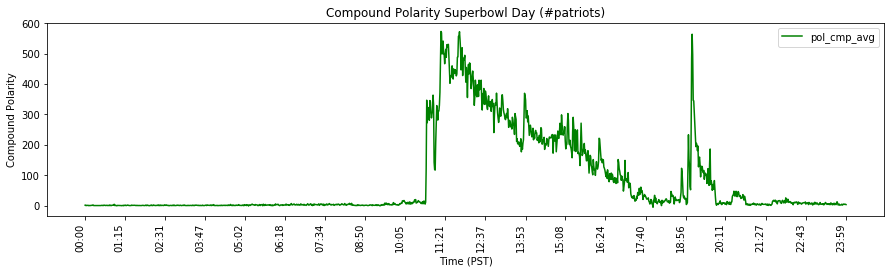

In [179]:
start = pd.to_datetime('2015-02-01 00:00:00-08:00')
stop = pd.to_datetime('2015-02-02 00:00:00-08:00')

df_pol_pats = df_polarities['patriots'].sort_values(by='citetime_pst')
df_pol_pats = df_pol_pats[(df_pol_pats['citetime_pst'] >= start) & (df_pol_pats['citetime_pst'] < stop)]
df_pol_pats_1m = pd.DataFrame(df_pol_pats.groupby(pd.Grouper(key='citetime_pst', freq="1Min")).agg({'pol_cmp':'sum'}))
df_pol_pats_1m.columns = ['pol_cmp_avg']
df_pol_pats_1m.fillna(value=0, inplace=True)

idx = df_pol_pats_1m.index
groupcols = [idx.year, idx.month, idx.day, idx.hour, idx.minute]

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(3.95)
fig.autofmt_xdate()
ax = df_pol_pats_1m.groupby(groupcols).agg({'pol_cmp_avg':'sum'}).plot(ax=ax, kind="line", color="green")
#ax = df_pol_pats_1m.groupby(groupcols).agg({'pol_cmp_avg':'mean'}).plot(ax=ax, kind="bar", color="green", width=1.0)
ax.set_title('Compound Polarity Superbowl Day (#patriots)')
ax.set_xlabel('Time (PST)')
ax.set_ylabel('Compound Polarity')

plt.xticks(rotation=90)
xtick_idx = np.linspace(0, len(df_pol_pats_1m) - 1, 20).astype(int)
xtick_labels = df_pol_pats_1m.index[xtick_idx]
xtick_labels = ["%02d:%02d" %(i.hour,i.minute) for i in xtick_labels]
ax.set_xticks(xtick_idx)
_ = ax.set_xticklabels(xtick_labels)


<p>The above graph shows much clearer the sentiment of Patriots fans on Superbowl day. It started off very optimistic, but then grew less optimistic over time as the Seahawks had the lead over the Patriots. The sentiment grew very positive again after the Patriots retook the lead at 18:50 and again after the game-saving interception at 19:00.</p>

In [215]:
df_pats = df_features['patriots'].sort_values(by='citetime_pst')
df_pats = df_pats[df_pats['citetime_pst'] >= pd.to_datetime('2015-02-01 18:50:30-08:00')]
df_pats.head(20)

citetime              citetime_pst        time    time_ori  \
379433 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379435 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379434 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379432 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379424 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379430 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379429 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379428 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379427 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379423 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379425 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379431 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379426 2015-02-02 02:50:30 2015-02-01 18:50:30-08:00  1422845430  1422845430   
379448 2015-02-02 02:50:31 2015-02-01 18:50:31-08:00  1422845431  1422845431   
379447 2015-02-02 02:50:31 2015-02-01 18:50:31-08:00  1422845431  1422845431   
379446 2015-02-02 02:50:31 2015-02-01 18:50:31-08:00  1422845431  1422845431   
379445 2015-02-02 02:50:31 2015-02-01 18:50:31-08:00  1422845431  1422845431   
379444 2015-02-02 02:50:31 2015-02-01 18:50:31-08:00  1422845431  1422845431   
379443 2015-02-02 02:50:31 2015-02-01 18:50:31-08:00  1422845431  1422845431   
379442 2015-02-02 02:50:31 2015-02-01 18:50:31-08:00  1422845431  1422845431   

                                           tweet_polarity  \
379433  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
379435  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
379434  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
379432  {'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'comp...   
379424  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
379430  {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...   
379429  {'neg': 0.113, 'neu': 0.66, 'pos': 0.226, 'com...   
379428  {'neg': 0.044, 'neu': 0.803, 'pos': 0.153, 'co...   
379427  {'neg': 0.091, 'neu': 0.788, 'pos': 0.12, 'com...   
379423  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
379425  {'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compou...   
379431  {'neg': 0.0, 'neu': 0.742, 'pos': 0.258, 'comp...   
379426  {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...   
379448  {'neg': 0.113, 'neu': 0.759, 'pos': 0.128, 'co...   
379447  {'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...   
379446  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
379445  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
379444  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
379443  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
379442  {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...   

                                               tweet_text  
379433          Now the game making sense again #Patriots  
379435  Não falo mais nada! Agora é segurar, ta muito ...  
379434             Patriots got this in the Bag #PATRIOTS  
379432  Patriots gotta win!!!!!!! Patriots gotta winn!...  
379424  Go Brady! Go Pats! Go Brady! Go Pats! #SuperBo...  
379430       Come on DEFENSE!!!! 👏👏👏 #Patriots #SuperBowI  
379429  2 minutes left to play in #SB49. #Patriots up ...  
379428  Brady did his job there. Now did #patriots lea...  
379427  28-24 N.E \nTD N.E BABY!\nBrady you better let...  
379423           What a game *_* #SuperbowlXLIX #Patriots  
379425  MY HERO ❤️🏈 #SuperBowlXLIX #SuperBowI #Patriot...  
379431  I've never ever rooted for the #Patriots befor...  
379426  Can you hear that? It's #PatriotsNation cheeri...  
379448  YES! There is absolutely nothing like watching...  
379447  RT @lucas_la0: TOUCHDOWN PATRIOOOOTS!!!!! #Pat...  
379446  #Patriots touchdown, putting them ahead 28-24 ...  
379445  TOUCHDOWN!!!! #Patriots reg